## Customer Segmentation using RFM Analysis and K-means Clustering

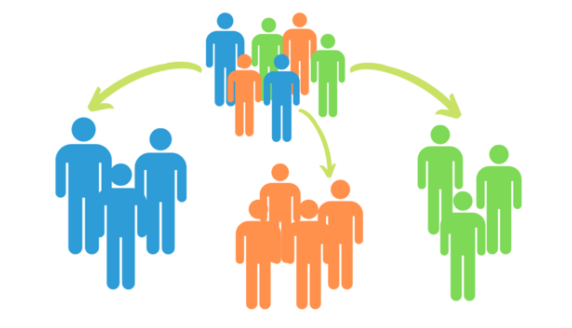

In [379]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)
from PIL import  Image

%matplotlib inline
plt.figure(figsize=(10,10))
img = np.array(Image.open(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\RFM_Analysis\cust_seg.png"))
plt.imshow(img,interpolation="bilinear")
plt.axis("off")
plt.show()


    Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.  In business-to-business marketing, a company might segment customers according to a wide range of factors, including: Industry. There are different type of segmentation.
   
            Geographic Customer Segmentation
            Demographic Customer Segmentation
            Behavioral Customer Segmentation
            Firmographic Customer segmentation
            Psychographic Customer Segmentation
            Smart customer segmentation
    
    In this project, Behavioral customer segmentation is performed using 
    
            1. RFM Analysis
            2. K-means Clustering

### 1. RFM Analysis    


            1. Visualize the R,F,M values to determine the cutoffs
            2. Segment the customers based on the cutoffs
            3. Profile the RFM segments
            4. Visualize the churn rate across the segments
    
    RFM is a strategy for analyzing and estimating the value of a customer, based on three data  
    points: 
            Recency (How recently did the customer make a purchase?)
            Frequency (How often do they purchase)
            Monetary Value (How much do they spend?)
            
            These three factors can be used to reasonably predict how likely (or unlikely)
            it is that a customer will re-purchase from a company. 
    
    An RFM analysis evaluates which customers are of highest and lowest value to an organization
    based on purchase recency, frequency, and monetary value, in order to reasonably predict 
    which customers are more likely to make purchases again in the future.

### Importing the dataframe and subsetting the RFM columns

In [380]:
import os
os.chdir("D:\Sunny_Personal\OSU MSBA\Fall 2019\BAN5561_CLV")
churn_df=pd.read_csv("churn_data.csv")

#Creating a dataframe for RFM Analysis
RFM=churn_df[['acct_ID','months_since_last_trans','order_cnt_36mo','purch_amt_36mo']]
RFM.rename(columns={'months_since_last_trans':'recency',
                    'order_cnt_36mo':'frequency',
                    'purch_amt_36mo':'monetary'},inplace=True)

print('Recency is months since last transaction')
print('Frequency is number of orders made in the last 36 months')
print('Monetary value is the amount made from the customer in the last 36months\n')

RFM.head()

Recency is months since last transaction
Frequency is number of orders made in the last 36 months
Monetary value is the amount made from the customer in the last 36months



,acct_ID,recency,frequency,monetary
0,B102465045,2,1,14619.5
1,B106897643,4,8,3179.0
2,B111832829,8,1,300.0
3,B112883062,1,6,700.0
4,B113581008,4,6,8560.0


In [381]:
def check_duplicates(df1):
    count1=df1['acct_ID'].nunique()
    count2=df1.shape[0]
    if(count1==count2):
        print('There are no duplicates')
    else:
        if(count1>count2):
            print('There are few records missing')
        else:
            duplicate_count[0]=RFM[RFM['acct_ID'].duplicated()]['acct_ID'].count()
            print('There are '+str(duplicate_count[0])+' duplicates ')

In [382]:
#Checking for the duplicates in the data
check_duplicates(RFM)

There are 97 duplicates 


In [383]:
#Grouping by acct_ID
#consider minimum recency
#Sum of the frequencies
#sum of the monetary values
RFM_clean=RFM.groupby(['acct_ID']).agg({'recency':'min',
                              'frequency':'sum',
                              'monetary':'sum'}).reset_index()

In [384]:
#Ensuring there are no duplicates in the data
check_duplicates(RFM_clean)

There are no duplicates


### Exploratory Data Analysis to decide the ranges for RFM

### Recency

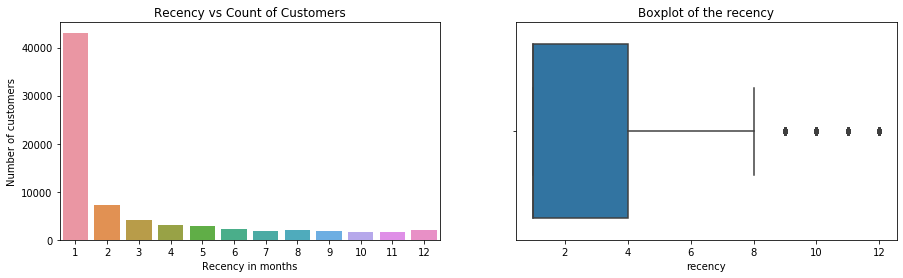

In [385]:
recency_grouped=RFM_clean.groupby(['recency'])['acct_ID'].count().reset_index()

plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
sns.barplot(x='recency',y='acct_ID',data=recency_grouped)
plt.title('Recency vs Count of Customers')
plt.xlabel('Recency in months')
plt.ylabel('Number of customers')
plt.subplot(1, 2, 2)
sns.boxplot(RFM_clean['recency'])
plt.title('Boxplot of the recency')
plt.show()

### Frequency

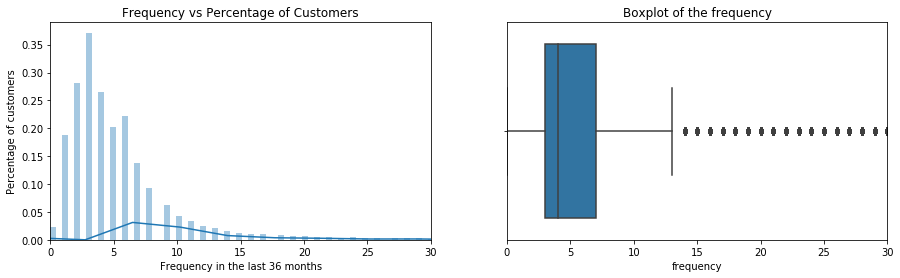

In [386]:
plt.figure(figsize=(15,4))
plt.subplot(1, 2, 1)
sns.distplot(RFM_clean['frequency'],bins=1000)
plt.xlim(0,30)
plt.title('Frequency vs Percentage of Customers')
plt.xlabel('Frequency in the last 36 months')
plt.ylabel('Percentage of customers')
plt.subplot(1, 2, 2)
sns.boxplot(RFM_clean['frequency'])
plt.xlim(0,30)
plt.title('Boxplot of the frequency')
plt.show()

### Using Quantiles to split the R,F,M into segments

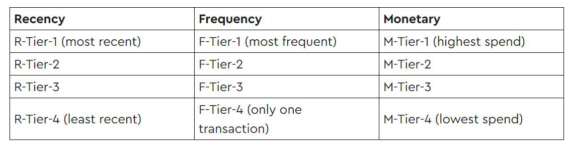

In [387]:
from PIL import  Image


%matplotlib inline
plt.figure(figsize=(10,10))
img = np.array(Image.open(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\RFM_Analysis\RFM.jpg"))
plt.imshow(img,interpolation="bilinear")
plt.axis("off")
plt.show()

The whole point of the RFM Analysis is consider different combinations of them to define how 
profitable a customer is. The customers can be classified as:

    #Recent customer is a better customer. Lower the Recency, better a customer is
    #Frequent customer is a better customer. More the Frequency, better a customer is
    #Highest Spending customer is a better customer.More the Monetary value, better a customer is
   
           Best Customers – This group consists of those customers who are found in R-Tier-1, 
           F-Tier-1 and M-Tier-1, meaning that they transacted recently, do so often and 
           spend more than other customers. A shortened notation for this segment is 1-1-1
           
           High-spending New Customers –This group consists of those customers in 1-4-1 and 1-4-2. 
           These are customers who transacted only once, but very recently and they spent a lot.
           
           Lowest-Spending Active Loyal Customers – This group consists of those customers in 
           segments 1-1-3 and 1-1-4(they transacted recently and do so often,but spend the least).

           Churned Best Customers –This segment consists of those customers in groups 4-1-1,4-1-2, 
           4-2-1 and 4-2-2(they transacted frequently and spent a lot, but it’s been a long time 
           since they’ve transacted).
    
    
https://www.optimove.com/resources/learning-center/rfm-segmentation
    

In [388]:
quartiles =RFM_clean.quantile(q=[0.25,0.50,0.75])
print('The Ranges of RFM are \n')
print(str(quartiles.transpose())+'\n')
print('Around 50% of the customers have made a purchase in the last month')
print('Around 25% of the customers have more than 7 purchases in the last 36 months')
print('Around 25% of the customers have spend more than 1060$ in the last 36months \n')

print('The numbers that are used for diving customers in RFM segments are \n')
quartiles=quartiles.to_dict()
quartiles

The Ranges of RFM are 

            0.25   0.50    0.75
recency      1.0    1.0     4.0
frequency    3.0    4.0     7.0
monetary   160.0  513.0  1060.0

Around 50% of the customers have made a purchase in the last month
Around 25% of the customers have more than 7 purchases in the last 36 months
Around 25% of the customers have spend more than 1060$ in the last 36months 

The numbers that are used for diving customers in RFM segments are 



{'recency': {0.25: 1.0, 0.5: 1.0, 0.75: 4.0},
 'frequency': {0.25: 3.0, 0.5: 4.0, 0.75: 7.0},
 'monetary': {0.25: 160.0, 0.5: 513.0, 0.75: 1060.0}}

### Defining functions for segmenting customers

In [389]:
## for Recency 

def Recency_segment(x,dict_column,dict_name):
    #RFM_clean[RFM_clean['recency']<quartiles['recency'][0.25]]
    if x <= dict_name[dict_column][0.25]:
        return 1
    elif x <= dict_name[dict_column][0.50]:
        return 2
    elif x <= dict_name[dict_column][0.75]: 
        return 3
    else:
        return 4

#For recency and monetary value
def Frequecny_monetary_segment(x,dict_column,dict_name):
    if x <= dict_name[dict_column][0.25]:
        return 4
    elif x <= dict_name[dict_column][0.50]:
        return 3
    elif x <= dict_name[dict_column][0.75]: 
        return 2
    else:
        return 1   

### Applying custom functions to segment the customers

In [390]:
RFM_clean['R_segment'] = RFM_clean['recency'].apply(Recency_segment, args=('recency',quartiles,))
RFM_clean['F_segment'] = RFM_clean['frequency'].apply(Frequecny_monetary_segment, args=('frequency',quartiles,))
RFM_clean['M_segment'] = RFM_clean['monetary'].apply(Frequecny_monetary_segment, args=('monetary',quartiles,))

### Creating RFM segment using the individual R,F and M segments

In [391]:
RFM_clean['RFMClass'] = RFM_clean.R_segment.map(str) \
                            + RFM_clean.F_segment.map(str) \
                            + RFM_clean.M_segment.map(str)

RFM_clean.sort_values(by=['RFMClass', 'monetary'], ascending=[True, False],inplace=True)

### Visualize the means of the RFM segments

In [392]:
RFM_mean=RFM_clean.groupby(['RFMClass']).agg({'recency':'mean',
                                     'frequency':'mean',
                                    'monetary':'mean',
                                     }).reset_index()

RFM_mean.head()

,RFMClass,recency,frequency,monetary
0,111,1.0,14.78,3728.80
1,112,1.0,15.22,768.57
2,113,1.0,18.75,339.31
3,114,1.0,21.66,86.60
4,121,1.0,6.02,2786.70


### Visualizing Churn Rate across the segments

As RFM segment tends to get worser, the Churn probability is increasing
Quadrant Analysis can be performed using a combination of two segment out 
of R,F,M segements depending on the business requirements


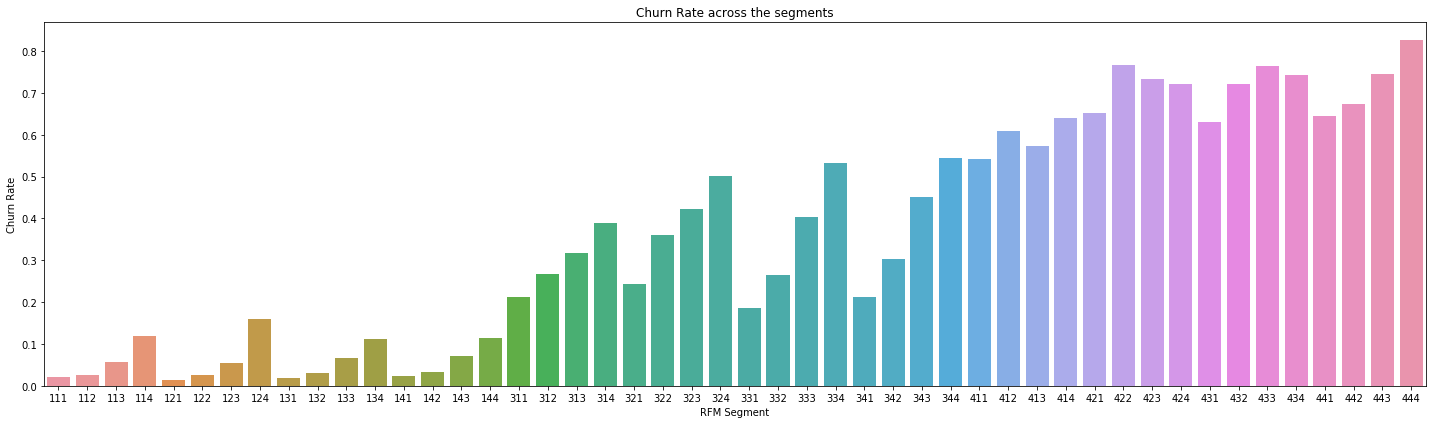

In [393]:
#subsetting the churn indicator and account ID
RFM_churn=churn_df[['acct_ID','churn_year_plus1_ind']]
RFM_churn.drop_duplicates(subset='acct_ID',keep='first',inplace=True)
#joining churn data with the RFM segment data
RFM_final=pd.merge(RFM_clean,RFM_churn,on='acct_ID')

#Grouping data by RFM class and calculate churn Rate
RFM_churn_rates=RFM_final.groupby(['RFMClass']).agg({'churn_year_plus1_ind':'mean'}).reset_index()
RFM_churn_rates.rename(columns={'churn_year_plus1_ind':'churn_rate'},inplace=True)

#Plotting barchart with RFM Class against the churn rate
plt.figure(figsize=(20,6))
sns.barplot(x='RFMClass',y='churn_rate',data=RFM_churn_rates)
plt.title('Churn Rate across the segments')
plt.xlabel('RFM Segment')
plt.ylabel('Churn Rate')
plt.tight_layout()
print('As RFM segment tends to get worser, the Churn probability is increasing')
print('Quadrant Analysis can be performed using a combination of two segment out \n'+
      'of R,F,M segements depending on the business requirements')

## 2. Customer Segmentation using K- Means Clustering

            1. Check the skewness of the variables ( Skewed variables give unstable clusters )
            2. Tranform the variables if required
            3. Scale the variables ( Raw variables might have different units )
            4. Try multiple K- values and choose elbow method to choose k
            5. Perform K-means clustering
            6. Profile the clusters
            7. Visualize the churn rate across the clusters

In [394]:
clustering_data=RFM_clean[['recency','frequency','monetary','acct_ID']]

print('The skewness of the variables are ')
skewness=clustering_data.skew(axis = 0, skipna = True,numeric_only=True).sort_values(ascending=False) 
skewness[(skewness>1.5) | (skewness<-1.5)]

The skewness of the variables are 


monetary     56.45
frequency    12.43
recency       1.62
dtype: float64

In [395]:
import warnings
warnings.filterwarnings("ignore")

#Applying variable transformations for stable clustering results
clustering_data['monetary_trans']=np.log(clustering_data['monetary']+0.01)
clustering_data['frequency_trans']=np.log(clustering_data['frequency']+0.01)
print('The skewness of the variables are ')
skewness=clustering_data.skew(axis = 0, skipna = True,numeric_only=True).sort_values(ascending=False) 
skewness

The skewness of the variables are 


monetary           56.45
frequency          12.43
recency             1.62
monetary_trans     -0.33
frequency_trans    -1.89
dtype: float64

In [396]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

scaler = MinMaxScaler()  
clustering_data_scaled = scaler.fit_transform(clustering_data[['monetary_trans','frequency_trans','recency']])

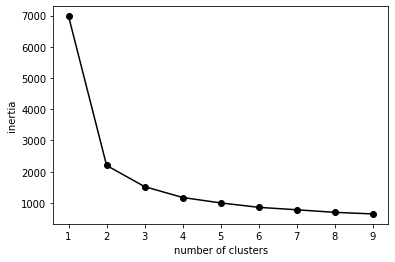

In [397]:
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    # Fit model to 3 PC's
    model.fit(clustering_data_scaled)
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Performing K-means Clustering with k=4

In [419]:
model = KMeans(n_clusters=4)
model.fit(clustering_data_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [420]:
Cluster_info=pd.DataFrame(model.labels_)
Cluster_info.rename(columns={0:'cluster'},inplace=True)
Clustering_fin=pd.concat([clustering_data,Cluster_info],axis=1)

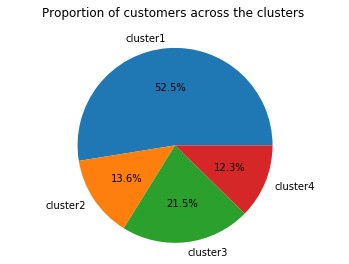

In [422]:
# Looking at the values of Yes and No's in the target variable CHURN
labels = ['cluster1','cluster2','cluster3','cluster4']
sizes = [Clustering_fin['cluster'].value_counts()[0],
         Clustering_fin['cluster'].value_counts()[1],
        Clustering_fin['cluster'].value_counts()[2],
        Clustering_fin['cluster'].value_counts()[3]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title('Proportion of customers across the clusters \n')
plt.show()

### Visualizing the clusters

In [423]:
Cluster_info=Clustering_fin.groupby(['cluster']).agg({'recency':'mean',
                                     'frequency':'mean',
                                    'monetary':'mean',
                                     }).reset_index()

cluster_final=pd.merge(Clustering_fin,RFM_churn,on='acct_ID')

#Grouping data by RFM class and calculate churn Rate
cluster_churn_rates=cluster_final.groupby(['cluster']).agg({'churn_year_plus1_ind':'mean'}).reset_index()
cluster_churn_rates.rename(columns={'churn_year_plus1_ind':'churn_rate'},inplace=True)

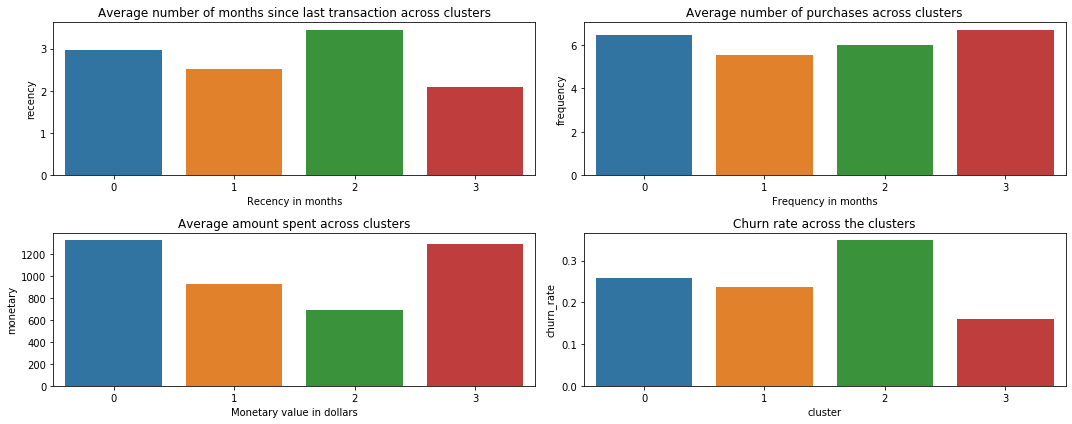

In [424]:
plt.figure(figsize=(15,6))

#Recency
plt.subplot(2, 2, 1)
sns.barplot(x='cluster',y='recency',data=Cluster_info)
plt.title('Average number of months since last transaction across clusters')
plt.xlabel('Recency in months')

#Frequency
plt.subplot(2, 2, 2)
sns.barplot(x='cluster',y='frequency',data=Cluster_info)
plt.title('Average number of purchases across clusters')
plt.xlabel('Frequency in months')

#Monetary Value
plt.subplot(2, 2, 3)
sns.barplot(x='cluster',y='monetary',data=Cluster_info)
plt.title('Average amount spent across clusters')
plt.xlabel('Monetary value in dollars')

#Churn Rate
plt.subplot(2, 2, 4)
sns.barplot(x='cluster',y='churn_rate',data=cluster_churn_rates)
plt.title('Churn rate across the clusters')
plt.tight_layout()

### Insights from the cluster analysis


#### Cluster 2 - Profitable Customers - Stars
          
              Recency            - Lowest
              Frequency          - Highest
              Monetary spendings - Highest
              churn Rate         - Lowest
                    
#### Cluster 3 -  Non-Profitable clusters with high risk of churning -  Under Dogs
                
              Recency            - Highest
              Frequency          - Lowest
              Monetary spendings - Lowest
              churn Rate         - Highest
       
#### Cluster 0 - Profitable customers with greater risk of churning - Cash Cows
  
              Recency            - Higher
              Frequency          - Highest
              Monetary spendings - Highest
              churn Rate         - Highest
              
#### Cluster 1 - Non-Profitable customers with lesser risk of churning - Wild Cats
  
              Recency            - Higher
              Frequency          - Highest
              Monetary spendings - Highest
              churn Rate         - Highest
              
 

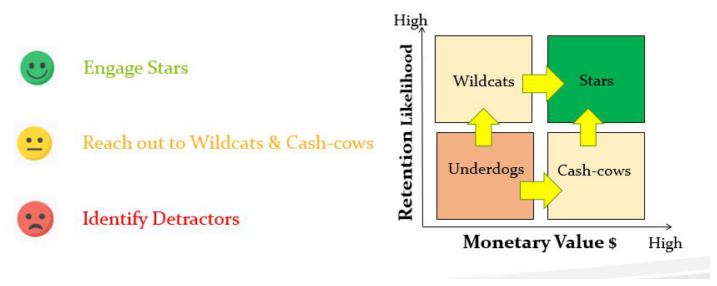

In [425]:
from PIL import  Image

%matplotlib inline
plt.figure(figsize=(15,5))
img = np.array(Image.open(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\RFM_Analysis\quadrants.jpg"))
plt.imshow(img,interpolation="bilinear")
plt.axis("off")
plt.show()

### Recommendations

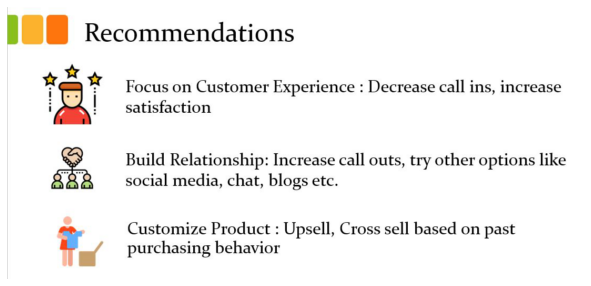

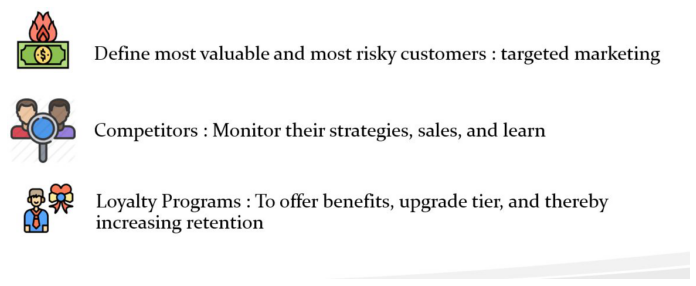

In [426]:
from PIL import  Image

%matplotlib inline
plt.figure(figsize=(15,5))
img = np.array(Image.open(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\RFM_Analysis\recommend_1.jpg"))
plt.imshow(img,interpolation="bilinear")
plt.axis("off")
plt.show()

from PIL import  Image

%matplotlib inline
plt.figure(figsize=(15,5))
img = np.array(Image.open(r"D:\Sunny_Personal\OSU MSBA\Fall 2019\GitHub\RFM_Analysis\recommend_2.jpg"))
plt.imshow(img,interpolation="bilinear")
plt.axis("off")
plt.show()